# Trabalho Acetilcolinesterase

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Rescaling
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, Model
import keras.backend as K
from sklearn.metrics import precision_score, accuracy_score, roc_auc_score, RocCurveDisplay, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
from IPython import display
from IPython.display import clear_output

%matplotlib inline

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("Invalid device or cannot modify virtual devices once initialized.")

gpus = len(physical_devices)
if gpus >= 1:
    print(f"{gpus} GPU OK")

1 GPU OK


## Parametros Globais

In [87]:
BATCH_SIZE = 16
IMG_SIZE = (480, 480)
CLASS_NAMES = [ 'negativo', 'positivo']
# class_names = ['negativo',"positivo"]
# class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

In [4]:
train_path = './data/train/'
test_path = './data/test/' 
reinhard_path = './data/reinhard'
full_path = './data/tmp/' 

## Funções utilitárias

In [5]:
def criar_diagrama_modelo(model, fname=None):
    if not fname:
        fname = './model_flowchart.png'
    tf.keras.utils.plot_model(model, to_file=fname, show_shapes=True)

In [6]:
def show_confusion_matrix(y_true, y_pred, labels):
    cnf_m = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cnf_m, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [7]:
def show_cam(image_value, features, results, upscaling):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''
  import scipy as sp
  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (upscaling, upscaling, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  print(cam_output.shape)
  p = tf.nn.sigmoid(results)
  # visualize the results
  print(f'sigmoid output: {p}')
  print(f"prediction: {'positivo' if p > 0.5 else 'negativo'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()

In [8]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image, upscaling=None, process=False):
    # load the image
    # img = cv2.imread(image)
    image = Image.open(image).resize(IMG_SIZE)
    image_t = tf.convert_to_tensor(image)

    if process:
        image_t = tf.cast(image_t, tf.float32)/255.0
    # preprocess the image before feeding it to the model
    # img = cv2.resize(img, (480,480)) / 255.0
    if not upscaling:
        upscaling = 480/4
    # add a batch dimension because the model expects it
    tensor_image = np.expand_dims(image_t, axis=0)

    # get the features and prediction
    features,results = cam_model.predict(tensor_image)

    # generate the CAM
    show_cam(tensor_image, features, results, upscaling=upscaling)


In [9]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [10]:
def test_image(fname, model, process=True, from_logits=False):
    image = Image.open(fname).resize(IMG_SIZE)
    predict = model.predict(image_to_tensor(image, process))
    
    if from_logits:
        predict = tf.math.sigmoid(predict)
        
    if predict < 0.5:
        title = 'negativo'
    
    else:
        title = 'positivo'
    
    plt.title(title)
    plt.imshow(image)
    print ("y = " + str(predict) )

In [11]:
def read_and_process_image(path, size=IMG_SIZE, process=None):
    image = Image.open(path).resize(size)
    image_t = tf.convert_to_tensor(image)
    image_t = tf.cast(image_t, tf.float32)/255.0
    if process:
        image_t = process(image_t) 
    
    return image_t

In [12]:
def image_to_tensor(image, process=True):
    image_t = tf.convert_to_tensor(image)
    image_t = tf.cast(image_t, tf.float32)
    if process:
        image_t /= 255.0 
    input_tensor = tf.expand_dims(image_t, axis=0)
    return input_tensor

In [13]:
def tensor_to_image(tensor):
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [14]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.RandomRotation(0.2))
    
    return data_augmentation

In [15]:
def my_pred(labels, preds):
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    print('Acurácia:', acc)
    print('Precisão:', precision)
    print('Recall:', recall)
    print('ROC AUC:', roc_auc)
    print('F1:', f1)

def get_labels_preds(model, test_ds, from_logits=None):
    probs = model.predict(test_ds, verbose=0)
    if from_logits:
        probs = tf.math.sigmoid(probs)
    preds = np.where(probs>0.5,1.0,0.0).squeeze()
    labels = np.vstack([y for x, y in test_ds]).squeeze()
    return labels, preds

In [16]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1, "As partiçoes devem somar 100% do ds"
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size+val_size).take(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
def plot_auc(y_true, y_pred):
    RocCurveDisplay.from_predictions(y_true, y_pred)

In [126]:
def classification_evaluation(classification, pred_labels, test_labels, test_images, n_cols=None):
    if classification == "correct":
        indices_list = np.where(pred_labels == test_labels)[0]
    else:
        indices_list = np.where(pred_labels != test_labels)[0]
        
    test_images_f = [test_images[i] for i in indices_list]
    test_labels_f = [test_labels[i] for i in indices_list]
    pred_labels_f = [pred_labels[i] for i in indices_list]
    
    print(f"{len(test_images_f)} images were classified {classification.upper()} out of a total of {len(test_images)} in the Test dataset")

    unique, counts = np.unique(test_labels_f, return_counts=True)
    
    for i in range(0,len(unique)):
        print(f"for category {CLASS_NAMES[int(unique[i])]} the number of {classification.upper()} classified images were: {counts[i]}")
        
    print("\n\n")
    zoom = 4
    n_cols = n_cols or len(test_images_f)
    n_rows = (len(test_images_f) - 1) // n_cols + 1
          
    plt.figure(figsize=(n_cols*zoom, (n_rows+1)*zoom))
    
    for index, t in enumerate(zip(test_images_f, test_labels_f, pred_labels_f)):
        image, label, pred = t
        image = image.astype(int)
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.title("Actual: " + CLASS_NAMES[ int(label[0]) ])
        plt.xlabel("Predicted: " + CLASS_NAMES[int(pred[0])], color='red')
        plt.axis("on")
        plt.xticks([])
        plt.yticks([])
   

In [45]:
def plot_batch(batch, n_cols=None, zoom=1):
    '''visualizes batch images'''
    display.clear_output(wait=False)  
    images, labels = batch
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols*zoom, (n_rows+1)*zoom))
    
    for index, t in enumerate(zip(images, labels)):
        image, label = t
        image = tensor_to_image(image)
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.title(CLASS_NAMES[int(label)])
        plt.axis("off")

In [20]:
def get_ds(path=None, split=.2, image_size=IMG_SIZE, batch= BATCH_SIZE):
    if split == None:
        subset = None
    else:
        subset = 'both'
        
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='binary',
        class_names=CLASS_NAMES,
        color_mode='rgb',
        batch_size=batch,
        image_size=image_size,
        shuffle=True,
        seed=17,
        validation_split=split,
        subset=subset,
    )

    return ds

In [21]:
def pre_process(image, label):
    tf.cast(image, tf.float32)
    image /= 255.0
    # tf.image.resize_with_crop_or_pad(image, IMG_SIZE[0], IMG_SIZE[1])
    return image, label

In [53]:
# involucro em torno do modelo para pegar imagens e labels durante predict do dataset de teste
class MyModel(tf.keras.Model):
    def predict_step(self, data):
        x, y = data
        return self(x, training=False), (x,y)

## Amostra de Imagens do Banco de Dados

In [54]:
#train_ds, valid_ds = get_ds(train_path)
#test_ds = get_ds(test_path, split=None)
full_ds = ds = tf.keras.utils.image_dataset_from_directory(
        full_path,
        labels='inferred',
        label_mode='binary',
        class_names=CLASS_NAMES,
        color_mode='rgb',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
    )


Found 337 files belonging to 2 classes.


In [55]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(full_ds, int(full_ds.cardinality()))

In [56]:
import os
path = './data/reinhard/.ipynb_checkpoints'
try:
    os.rmdir(path)
    print("directory is deleted")
except OSError as x:
    #print("Error occured: %s : %s" % (path, x.strerror))
    pass

In [57]:
reinhard_ds, rvalid_ds = get_ds(reinhard_path)

Found 252 files belonging to 2 classes.
Using 202 files for training.
Using 50 files for validation.


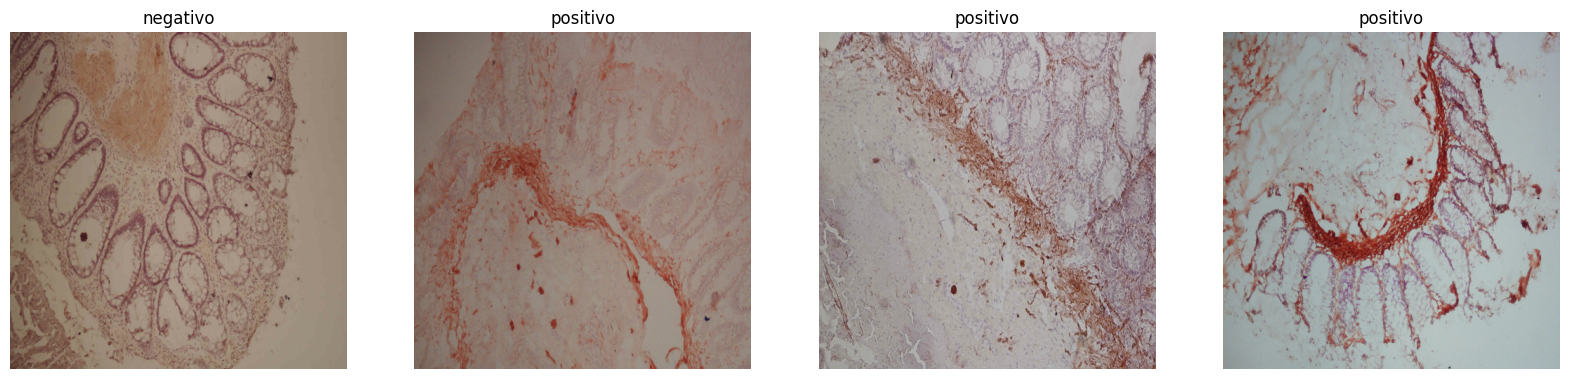

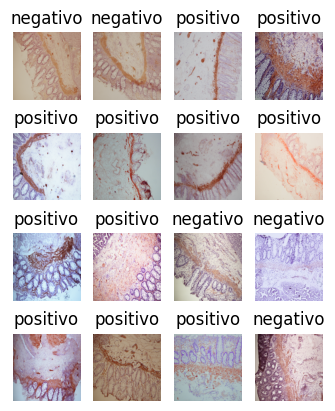

In [58]:
plot_batch(next(iter(train_ds.rebatch(4).take(1))), 4, zoom=5)
plot_batch(next(iter(val_ds.take(1))), 4)
#plot_batch(next(iter(test_ds.take(1))),4)

## Criando o modelo CNN simples 

$$[(W−K+2P)/S]+1$$
$$w= \text volume shape$$
### L1
- input_shape=(480,480,3)
- output_shape=(120, 120, 16)
- Filter size 3x3x16 strides=2 (increase features)
- Activation Relu
- Padding 'Same'
- MaxPool2D (reduce resolution 1/2)

### L2
- input_shape=(120,120,16)
- output_shape=(30, 30, 32)
- Filter size 3x3x32 strides=2 (increase features)
- Activation Relu
- Padding 'Same'
- MaxPool2D (reduce resolution 1/2)

### L3
- input_shape=(30,30,32)
- output_shape=(7, 7, 64)
- Filter size 3x3x64 strides=2
- Activation Relu
- Padding 'Same'

### L4
- input_shape=(7, 7, 64)
- output_shape=(4, 4, 128)
- Filter size 3x3x128 strides=2
- Activation Relu
- Padding 'Same'
- sem Maxpooling

### GlobalAveragePooling2D()
- input_shape=(4, 4, 128)
- output_shape=1
- Dense units=1
- Activation='sigmoid'

In [59]:
def build_cnn():
    he_initializer=tf.keras.initializers.HeNormal(seed=17)
    model = Sequential([
        
        Rescaling(scale=1./255),
        #L1
        Conv2D(filters=16, kernel_size=(3, 3), strides=2, activation='relu', padding = 'same',
               input_shape=(480,480,3,),
               kernel_initializer=he_initializer, 
               name='L1_conv'),
        MaxPool2D(pool_size=(2, 2), name='L1_maxpooling'),
        #L2
        Conv2D(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding = 'same',
               kernel_initializer=he_initializer,
               name= 'L2_conv'),
        MaxPool2D(pool_size=(2, 2), name='L2_maxpooling'),
        #L3
        Conv2D(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding = 'same',
               kernel_initializer=he_initializer,
               name='L3_conv'),
        MaxPool2D(pool_size=(2, 2), name='L3_maxpooling'),
        #L4
        Conv2D(filters=128, kernel_size=(3, 3),strides=2, activation='relu', padding = 'same',
               kernel_initializer=he_initializer,
               name='L4_conv'),
        
        GlobalAveragePooling2D(name='global_average_pooling'),
        Dense(units=1, activation='sigmoid')
        
    ])
    
    return model

## Cria classe com predict customizado para retornar labels and predictions

In [60]:
input = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
output = build_cnn()(input)
cnn_model = MyModel(input, output)

In [61]:
cnn_model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 1)                 97569     
                                                                 
Total params: 97569 (381.13 KB)
Trainable params: 97569 (381.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compilar Modelo CNN simples e Treinar

In [62]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [63]:
history = cnn_model.fit(x=train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=2
)

Epoch 1/30
17/17 - 3s - loss: 0.6947 - accuracy: 0.5214 - val_loss: 0.6872 - val_accuracy: 0.5312 - 3s/epoch - 180ms/step
Epoch 2/30
17/17 - 2s - loss: 0.6834 - accuracy: 0.5525 - val_loss: 0.6285 - val_accuracy: 0.7059 - 2s/epoch - 100ms/step
Epoch 3/30
17/17 - 2s - loss: 0.6577 - accuracy: 0.5837 - val_loss: 0.6199 - val_accuracy: 0.6250 - 2s/epoch - 101ms/step
Epoch 4/30
17/17 - 2s - loss: 0.6856 - accuracy: 0.6304 - val_loss: 0.6713 - val_accuracy: 0.3750 - 2s/epoch - 101ms/step
Epoch 5/30
17/17 - 2s - loss: 0.6616 - accuracy: 0.6693 - val_loss: 0.6134 - val_accuracy: 0.8750 - 2s/epoch - 101ms/step
Epoch 6/30
17/17 - 2s - loss: 0.6332 - accuracy: 0.7121 - val_loss: 0.5812 - val_accuracy: 0.6875 - 2s/epoch - 100ms/step
Epoch 7/30
17/17 - 2s - loss: 0.6060 - accuracy: 0.6887 - val_loss: 0.5652 - val_accuracy: 0.7500 - 2s/epoch - 98ms/step
Epoch 8/30
17/17 - 2s - loss: 0.5672 - accuracy: 0.7237 - val_loss: 0.6111 - val_accuracy: 0.6562 - 2s/epoch - 100ms/step
Epoch 9/30
17/17 - 2s - l

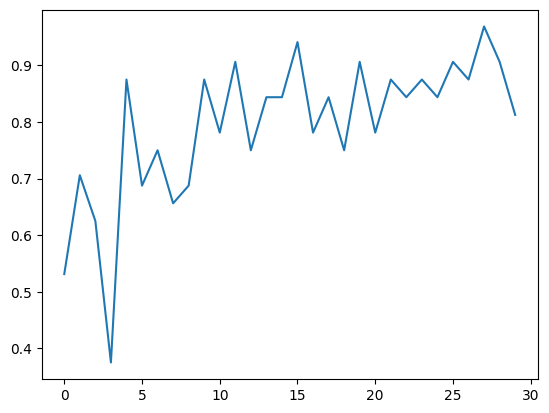

In [64]:
plt.plot(history.history['val_accuracy'])
plt.show()

In [66]:
probs, (images,labels) = cnn_model.predict(test_ds)
preds = np.where(probs>0.5, 1.0, 0.0)
confusion_matrix(preds, labels)

2/2 [==============================] - 1s 94ms/step


array([[ 9,  1],
       [ 2, 20]])

3 images were classified INCORRECT out of a total of 32 in the Test dataset
for category negativo the number of INCORRECT classified images were: 2
for category positivo the number of INCORRECT classified images were: 1





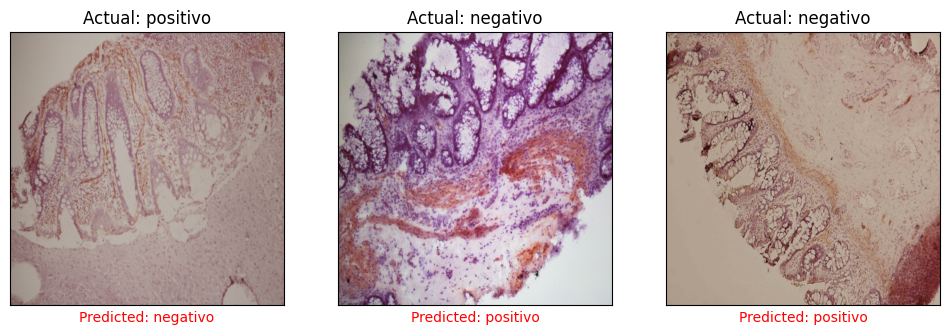

In [125]:
classification_evaluation('incorrect', preds, labels, images)

In [79]:
test_loss, test_acc = cnn_model.evaluate(test_ds, verbose=2)

print('\nTest accuracy:', test_acc)
my_pred(labels, preds)

2/2 - 1s - loss: 0.6934 - accuracy: 0.5625 - 1s/epoch - 555ms/step

Test accuracy: 0.5625
Acurácia: 0.625
Precisão: 0.65
Recall: 0.7222222222222222
ROC AUC: 0.6111111111111112
F1: 0.6842105263157895


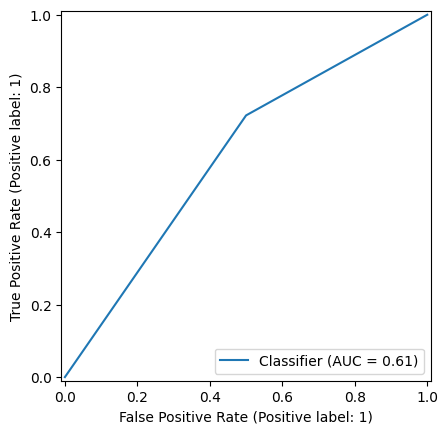

In [76]:
plot_auc(labels, preds)

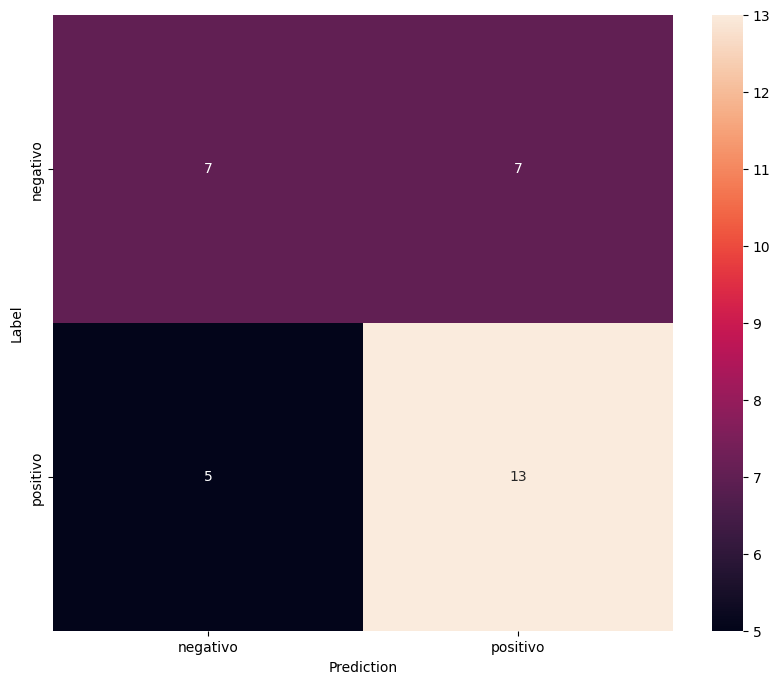

In [89]:
show_confusion_matrix(labels, preds, CLASS_NAMES)

## Predict sobre uma nova Imagem

1/1 [==============================] - 0s 225ms/step
y = [[0.999616]]


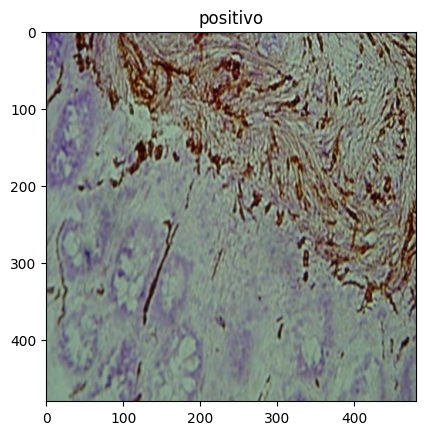

In [31]:
test_image(os.path.join(test_path, "positivo/test_pos-2.jpg"), model) 

1/1 [==============================] - 0s 17ms/step
y = [[0.14124838]]


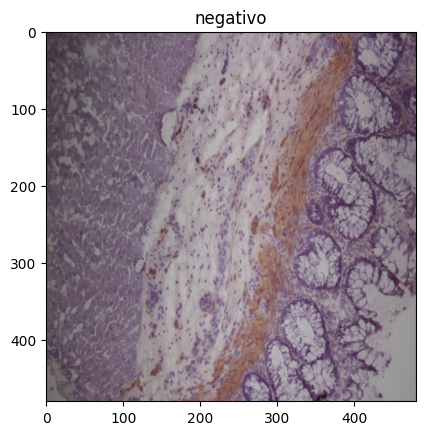

In [32]:
test_image(os.path.join(test_path, "negativo/test_neg-1.jpg"), model) 

# Class Activation Maps para o Modelo 1

In [33]:
gap_weights = model.layers[-1].get_weights()[0]

cam_model = tf.keras.Model(inputs=model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1_conv_input (InputLayer)  [(None, 480, 480, 3)]     0         
                                                                 
 L1_conv (Conv2D)            (None, 240, 240, 16)      448       
                                                                 
 L1_maxpooling (MaxPooling2  (None, 120, 120, 16)      0         
 D)                                                              
                                                                 
 L2_conv (Conv2D)            (None, 60, 60, 32)        4640      
                                                                 
 L2_maxpooling (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 L3_conv (Conv2D)            (None, 15, 15, 64)        18496 

1/1 [==============================] - 0s 416ms/step
(480, 480)
sigmoid output: [[0.73105854]]
prediction: positivo


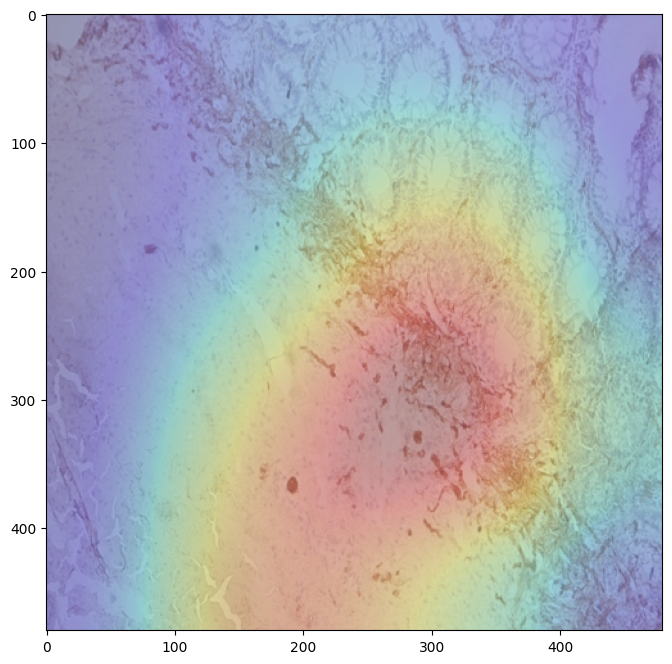

In [35]:
convert_and_classify(os.path.join(test_path, 'positivo/test_pos-3.jpg'))

1/1 [==============================] - 0s 15ms/step
(480, 480)
sigmoid output: [[0.73105854]]
prediction: positivo


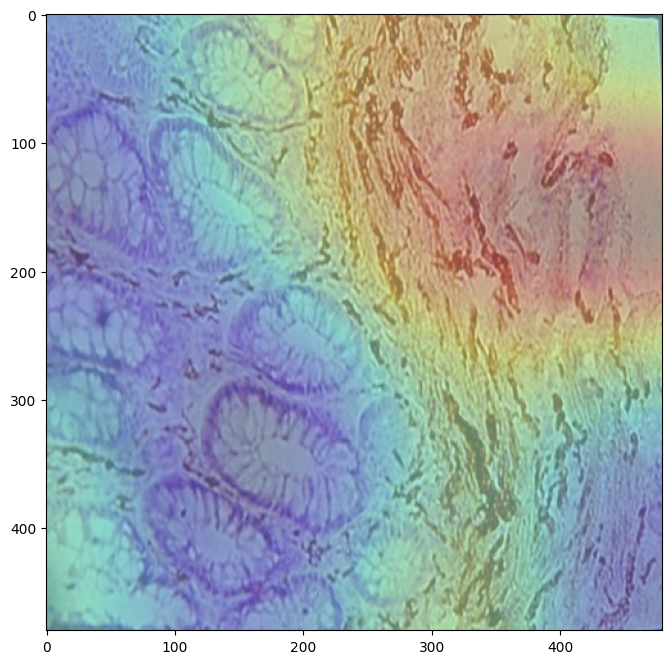

In [36]:
convert_and_classify(os.path.join(test_path, 'positivo/test_pos-1.jpg'))

1/1 [==============================] - 0s 17ms/step
(480, 480)
sigmoid output: [[0.73105854]]
prediction: positivo


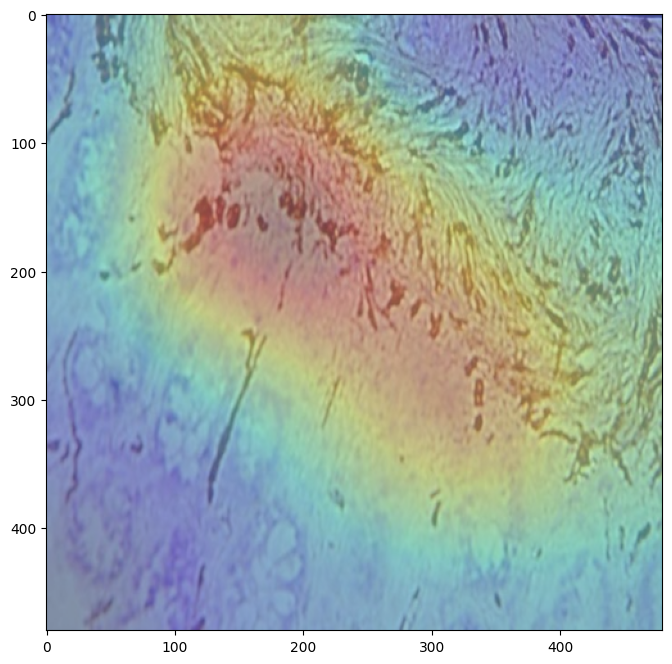

In [37]:
convert_and_classify(os.path.join(test_path, 'positivo/test_pos-2.jpg'))

1/1 [==============================] - 0s 14ms/step
(480, 480)
sigmoid output: [[0.5]]
prediction: negativo


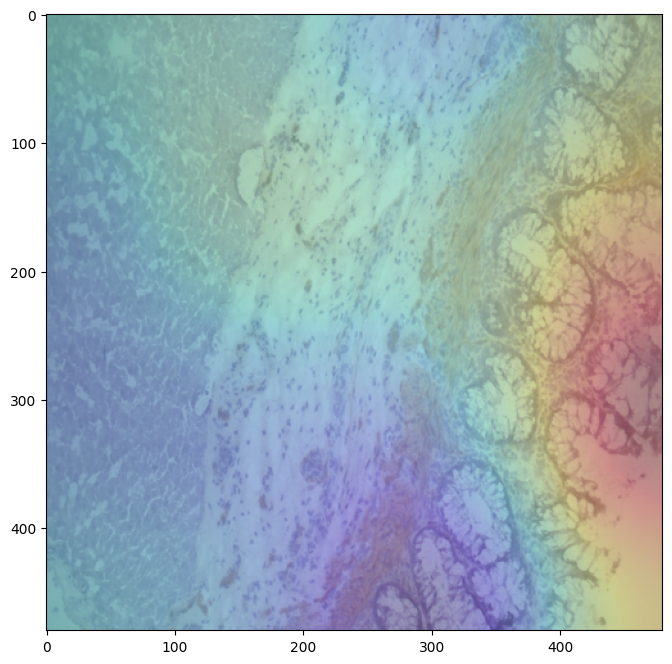

In [38]:
convert_and_classify(os.path.join(test_path, 'negativo/test_neg-1.jpg'))

## Implementing Saliency Grad Model

In [ ]:
def get_gradients(image, label, model):
    with tf.GradientTape() as tape:
        img = tf.cast(image, tf.float32)
        tape.watch(img)
        predictions = model(img)
        loss = tf.keras.losses.binary_crossentropy(label, predictions)
    gradients = tape.gradient(loss, img)
    
    return gradients

def read_image(path):
    import cv2
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img, (480, 480)) / 255.0
    image = np.expand_dims(img, axis=0)
    
    return image

In [ ]:
img = read_image(os.path.join(test_path, 'test_pos-2.jpg'))

In [ ]:
positivo_label = tf.constant(1.,shape=(1,1))
negativo_label = tf.constant(0.,shape=(1,1))
prediction = model(img)
print(prediction)
print(positivo_label)

In [ ]:
gradients = get_gradients(img, positivo_label, model)
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)


In [ ]:
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

In [ ]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

# coordinates of the first pixel where the max and min values are located
max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
print(max_pixel)
print(min_pixel)
print()

# these coordinates should have the max (255) and min (0) value in the normalized tensor
print(normalized_tensor[max_pixel])
print(normalized_tensor[min_pixel])

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

In [ ]:

gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_TURBO)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(np.squeeze(img), 0.6, gradient_color, 0.4, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()

## Implementando GradCAM
[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
# selecionar todas as camadas da visualização
outputs = [layer.output for layer in model.layers[1:9]]

# Definir um novo modelo com a saída das camadas acima
vis_model = Model(model.input, outputs)

# guardar os nomes das camadas de interesse
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Camadas utilizadas na visualização: ")
print(layer_names)

In [ ]:
def get_CAM(processed_image, actual_label, layer_name='L4_conv'):
    model_grad = Model([model.inputs], 
                       [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        # watch the conv_output_values
        tape.watch(conv_output_values)

        ## Use binary cross entropy loss
        ## actual_label is 0 if cat, 1 if dog
        # get prediction probability of dog
        # If model does well, 
        # pred_prob should be close to 0 if cat, close to 1 if dog
        pred_prob = predictions[:,0] 
        
        # make sure actual_label is a float, like the rest of the loss calculation
        actual_label = tf.cast(actual_label, dtype=tf.float32)
        
        # add a tiny value to avoid log of 0
        smoothing = 0.00001 
        
        # Calculate loss as binary cross entropy
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(f"binary loss: {loss}")
    
    # get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()
    
    # weight the convolution outputs with the computed gradients
    for i in range(128): 
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [ ]:
def show_sample(idx=None):
    
    # if image index is specified, get that image
    if idx:
        for img, label in train_ds.take(idx):
            sample_image = img[0]
            sample_label = label[0]
    # otherwise if idx is not specified, get a random image
    else:
        for img, label in train_ds.shuffle(1000).take(1):
            sample_image = img[0]
            sample_label = label[0]
    
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    
    activations = vis_model.predict(sample_image_processed)
    
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    sample_activation = activations[0][0,:,:,15]
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    heatmap = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_img = sample_image.numpy()
    super_imposed_image = cv2.addWeighted(converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0)

    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return activations

In [ ]:
for img, label in valid_ds.shuffle(1000).take(1):
    sample_image = img[0]
    sample_label = label[0]
sample_image = tf.cast(sample_image, tf.float32)/255.0
processed_image = np.expand_dims(sample_image, axis=0)
model_grad = Model([model.inputs], 
                   [model.get_layer('L4_conv').output, model.output])


conv_output_values, predictions = model_grad(processed_image)
predictions[:,0]

In [ ]:
for img, label in valid_ds.shuffle(1000).take(1):
    sample_image = img[0]
    sample_label = label[0]

sample_image_processed = np.expand_dims(sample_image, axis=0)

activations = vis_model.predict(sample_image_processed)
a0 = activations[0]
#print(a0)


activations = show_sample(idx=None)

# Transfer Learning

## Model: EfficientNet V2 B0
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#B6EADA;
              border-bottom-style: solid;'></div>
<br>  

EfficientNetV2 is a convolutional neural network that has faster training speed and better parameter efficiency than previous EfficientNetV1 models. To develop these models, the authors use a combination of training-aware neural architecture search and scaling, to jointly optimize training speed. The models were searched from the search space enriched with new ops such as Fused-MBConv.

<center>
    <figure>
        <img src="https://i.postimg.cc/vBSTR3V0/59864ee4.png" alt ="MBConv and Fused-MBConv" style='width: 400px;'>
        <figcaption>
            Image Source: <a href="https://wandb.ai/wandb_fc/pytorch-image-models/reports/EfficientNetV2--Vmlldzo2NTkwNTQ">[Source]</a></figcaption>
    </figure>
</center>

**For more information follow the links below:**
> - EfficientNet V2 Paper (2021): [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/pdf/2104.00298v2.pdf)
> - [EfficientNet: Improving Accuracy and Efficiency through AutoML and Model Scaling](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)
> - [Wandb: EfficientNetV2](https://wandb.ai/wandb_fc/pytorch-image-models/reports/EfficientNetV2--Vmlldzo2NTkwNTQ)

<a id="tfhub"></a>
## TensorFlow Hub

TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. Reuse trained models like BERT and Faster R-CNN with just a few lines of code.

In this section we'll be using pre-trained models from TensorFlow Hub. 

> For more information on TensorFlow Hub or if you would like to access the same models in PyTorch/JAX, check out the following links:
> - [TensorFlow Hub](https://www.tensorflow.org/hub)
> - [HuggingFace🤗](https://huggingface.co/)

In [107]:
def build_efficientnet_v2():
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(input_shape=IMG_SIZE + (3,), weights='imagenet', include_top=False)
    output = layers.GlobalAveragePooling2D()(base_model.output)
    output = layers.Dense(1, activation='sigmoid')(output)
    model = Model(base_model.input, output)
    
    # treinar somente as últimas quatro camadas
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    #model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    #model.summary()                                               

    return model

In [129]:
model_efficientnet_v2 = build_efficientnet_v2()
input = model_efficientnet_v2.input
output = model_efficientnet_v2.output
model_efficientnet_v2 = MyModel(input, output)
model_efficientnet_v2.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [130]:
history = model_efficientnet_v2.fit(x=train_ds, validation_data=val_ds, epochs=20, verbose=2)

Epoch 1/20
17/17 - 13s - loss: 0.6009 - accuracy: 0.6576 - val_loss: 0.4202 - val_accuracy: 0.7812 - 13s/epoch - 786ms/step
Epoch 2/20
17/17 - 4s - loss: 0.3892 - accuracy: 0.8249 - val_loss: 0.2499 - val_accuracy: 0.9375 - 4s/epoch - 233ms/step
Epoch 3/20
17/17 - 4s - loss: 0.2292 - accuracy: 0.9377 - val_loss: 0.1587 - val_accuracy: 0.9688 - 4s/epoch - 232ms/step
Epoch 4/20
17/17 - 4s - loss: 0.2203 - accuracy: 0.9339 - val_loss: 0.1958 - val_accuracy: 0.8824 - 4s/epoch - 226ms/step
Epoch 5/20
17/17 - 4s - loss: 0.1925 - accuracy: 0.9339 - val_loss: 0.0814 - val_accuracy: 1.0000 - 4s/epoch - 235ms/step
Epoch 6/20
17/17 - 4s - loss: 0.1472 - accuracy: 0.9572 - val_loss: 0.1017 - val_accuracy: 0.9688 - 4s/epoch - 230ms/step
Epoch 7/20
17/17 - 4s - loss: 0.1703 - accuracy: 0.9339 - val_loss: 0.1114 - val_accuracy: 0.9688 - 4s/epoch - 233ms/step
Epoch 8/20
17/17 - 4s - loss: 0.1412 - accuracy: 0.9375 - val_loss: 0.0879 - val_accuracy: 0.9688 - 4s/epoch - 248ms/step
Epoch 9/20
17/17 - 4s 

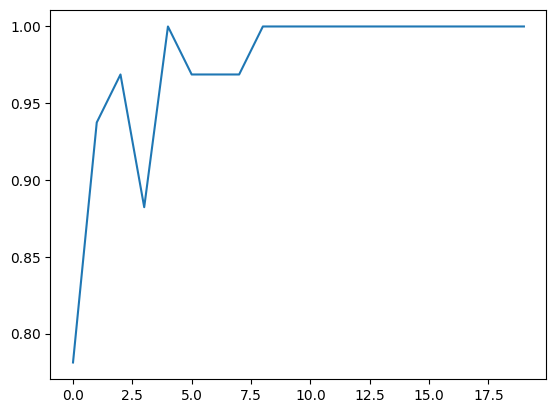

In [131]:
plt.plot(history.history['val_accuracy'])

In [134]:
#test_ds = get_ds(test_path, split=None)
#test_loss, test_acc = model_efficientnet_v2.evaluate(test_ds, verbose=2)
preds, labels = model_efficientnet_v2.predict(test_ds)
preds = np.where(preds>0.5, 1.0, 0.0)
print('\nTest accuracy:', test_acc)
my_pred(labels, preds)
confusion_matrix(labels, preds)


2/2 [==============================] - 3s 135ms/step

Test accuracy: 0.59375
Acurácia: 0.375
Precisão: 0.0
Recall: 0.0
ROC AUC: 0.5
F1: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[12,  0],
       [20,  0]])

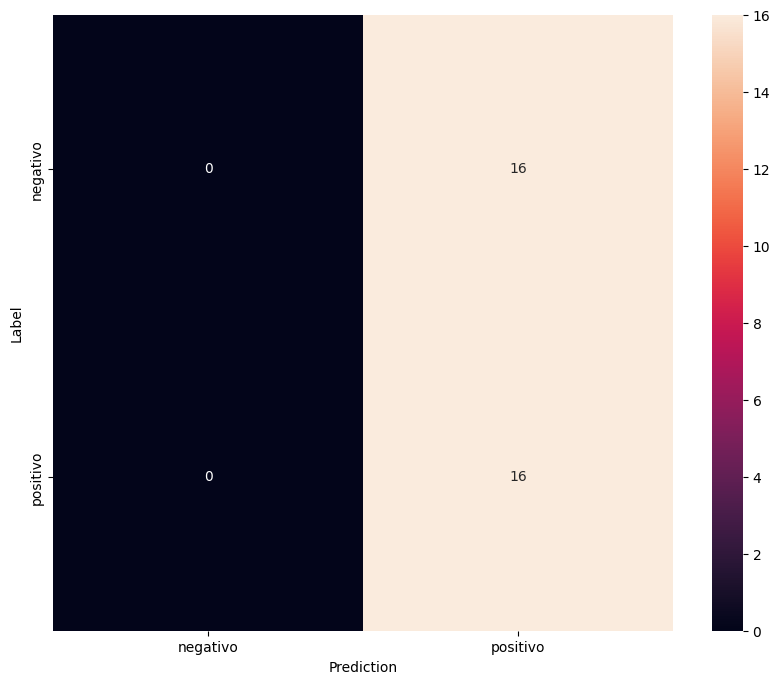

In [117]:
show_confusion_matrix(labels, preds, CLASS_NAMES)

1/1 [==============================] - 2s 2s/step
y = [[0.38526234]]


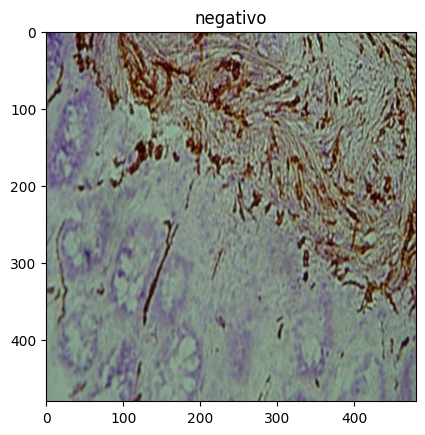

In [44]:
test_image(os.path.join(test_path, "positivo/test_pos-2.jpg"), model_efficientnet_v2, process=False) 

In [ ]:
gap_weights = model_efficientnet_v2.layers[-1].get_weights()[0]

cam_model = tf.keras.Model(inputs=model_efficientnet_v2.input, outputs=(model_efficientnet_v2.layers[-3].output, model_efficientnet_v2.layers[-1].output))
cam_model.summary()

In [ ]:
convert_and_classify(os.path.join(test_path, "test_pos-2.jpg"), upscaling=480/15, process=False)

In [ ]:
convert_and_classify(os.path.join(test_path, "test_pos-1.jpg"), upscaling=480/15, process=False)

## VGG16

![Arquitetura](https://www.researchgate.net/profile/Max_Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png)

### Alterações no modelo original para transfer learning
- Removido 'top' => camadas FC do final do modelo 
- Adicionado Camada GlobalAveragePooling() com input_shape=7x7x512 e output=(512,)
- Adicionado Classifier simples com um neurônio sem ativações => from_logits=true na loss function BinaryCrossentropy
- Congelada todas as camadas para treinamento com exceção das últimas 4
- Adicionado segundo tempo de treinamento com learning rate=1e-5 e 5 epochs para ajuste fino com cuidado para evitar overfitting

In [25]:
def build_vgg():
    input_shape = IMG_SIZE + (3,)
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable= False
    x = tf.keras.applications.vgg16.preprocess_input(base_model.input)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(units=1, activation='sigmoid')(x)

    model = Model(base_model.input, output)

    for layer in base_model.layers[:-4]:
        layer.trainable=False

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    #model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=[keras.metrics.BinaryAccuracy(),])# keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])
  
    model.summary()
  
    return model

In [28]:
K.clear_session()
vgg = build_vgg()
model_vgg = MyModel(vgg.input, vgg.output)
model_vgg.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=[keras.metrics.BinaryAccuracy()])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 480, 480, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 480, 480, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 15, 15, 512)       14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [29]:
history = model_vgg.fit(x=train_ds,
    validation_data=val_ds,
    epochs=20,
    #callbacks=[PlotLearning()],
    verbose=2
)

Epoch 1/20


2024-02-15 23:18:50.027474: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-02-15 23:18:50.492642: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-15 23:18:50.742837: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-15 23:18:51.011534: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

17/17 - 20s - loss: 0.6590 - binary_accuracy: 0.5992 - val_loss: 0.7641 - val_binary_accuracy: 0.5625 - 20s/epoch - 1s/step
Epoch 2/20
17/17 - 6s - loss: 0.5679 - binary_accuracy: 0.6887 - val_loss: 0.4705 - val_binary_accuracy: 0.7188 - 6s/epoch - 325ms/step
Epoch 3/20
17/17 - 5s - loss: 0.4975 - binary_accuracy: 0.7743 - val_loss: 0.4217 - val_binary_accuracy: 0.8438 - 5s/epoch - 314ms/step
Epoch 4/20
17/17 - 6s - loss: 0.4543 - binary_accuracy: 0.7904 - val_loss: 0.3544 - val_binary_accuracy: 0.9062 - 6s/epoch - 324ms/step
Epoch 5/20
17/17 - 5s - loss: 0.4377 - binary_accuracy: 0.8171 - val_loss: 0.4576 - val_binary_accuracy: 0.8438 - 5s/epoch - 310ms/step
Epoch 6/20
17/17 - 5s - loss: 0.3746 - binary_accuracy: 0.8794 - val_loss: 0.4803 - val_binary_accuracy: 0.8438 - 5s/epoch - 318ms/step
Epoch 7/20
17/17 - 5s - loss: 0.3677 - binary_accuracy: 0.8713 - val_loss: 0.3201 - val_binary_accuracy: 0.8750 - 5s/epoch - 323ms/step
Epoch 8/20
17/17 - 5s - loss: 0.3650 - binary_accuracy: 0.85

In [30]:
#test_ds = get_ds(test_path)
preds, labels = model_vgg.predict(test_ds)
preds = np.where( preds>0.5, 1.0,0.0)
confusion_matrix(labels, preds)

2/2 [==============================] - 1s 211ms/step


array([[11,  1],
       [ 0, 20]])

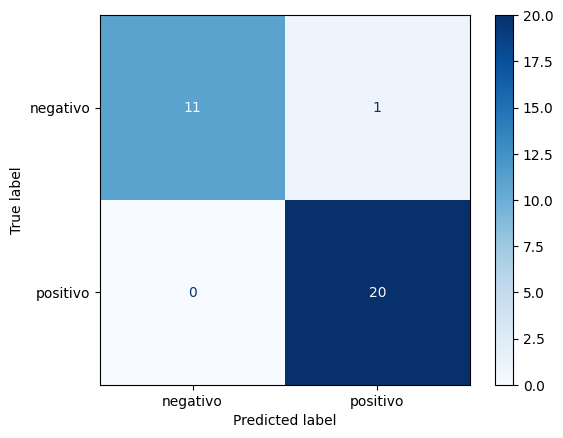

In [33]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [152]:
#test_ds = get_ds(test_path, split=None)
test_loss, test_acc = model_vgg.evaluate(test_ds, verbose=2)

print('Test accuracy:', test_acc)
   

2/2 - 1s - loss: 0.2888 - binary_accuracy: 0.8750 - 1s/epoch - 739ms/step
Test accuracy: 0.875


In [ ]:
def plot_img_pred(batch, n_cols=None):
    
    display.clear_output(wait=False)  
    images, labels = batch
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows+1))
    
    for index, t in enumerate(zip(images, labels)):
        image, label = t
        image = tensor_to_image(image)
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.title(CLASS_NAMES[int(label)])
        plt.axis("off")

## Fine tuning VGG16

In [153]:
model_vgg.trainable = True 

for layer in model_vgg.layers:
        layer.trainable=True

# compilar novamente o modelo com novo learning rate e para desbloquear as camadas
model_vgg.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
model_vgg.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/5
17/17 [==============================] - 36s 857ms/step - loss: 0.2581 - binary_accuracy: 0.9027 - val_loss: 0.2596 - val_binary_accuracy: 0.8125
Epoch 2/5
17/17 [==============================] - 12s 691ms/step - loss: 0.2748 - binary_accuracy: 0.8755 - val_loss: 0.2438 - val_binary_accuracy: 0.9062
Epoch 3/5
17/17 [==============================] - 12s 690ms/step - loss: 0.1358 - binary_accuracy: 0.9533 - val_loss: 0.0677 - val_binary_accuracy: 0.9688
Epoch 4/5
17/17 [==============================] - 13s 728ms/step - loss: 0.0729 - binary_accuracy: 0.9816 - val_loss: 0.0296 - val_binary_accuracy: 1.0000
Epoch 5/5
17/17 [==============================] - 12s 694ms/step - loss: 0.0255 - binary_accuracy: 0.9961 - val_loss: 0.0258 - val_binary_accuracy: 1.0000


## Avaliando as Métricas

In [159]:
preds, labels = model_vgg.predict(test_ds)
preds = np.where( preds>0.5, 1.0,0.0)

# my_pred(vgg, test_ds)
test_loss, test_acc= model_vgg.evaluate(test_ds, verbose=2)

print('Test accuracy:', test_acc)
# print('Test precision:', precision)
# print('Test recall:', recall)
# print('Test F1:', F1)
my_pred(labels, preds)

2/2 [==============================] - 1s 214ms/step
2/2 - 1s - loss: 0.0064 - binary_accuracy: 1.0000 - 1s/epoch - 583ms/step
Test accuracy: 1.0
Acurácia: 1.0
Precisão: 1.0
Recall: 1.0
ROC AUC: 1.0
F1: 1.0


In [156]:
confusion_matrix(labels, preds)

array([[15,  0],
       [ 0, 17]])

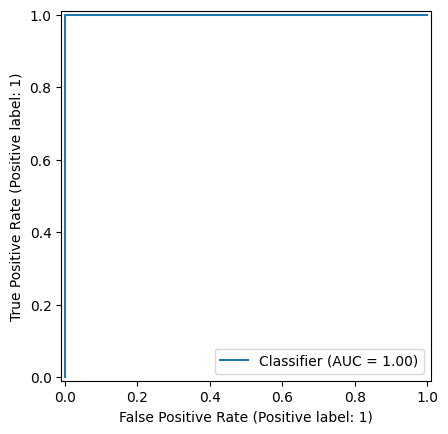

In [157]:
plot_auc(labels, preds)

In [61]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, probs, labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

1/1 [==============================] - 1s 1s/step
y = tf.Tensor([[0.5704038]], shape=(1, 1), dtype=float32)


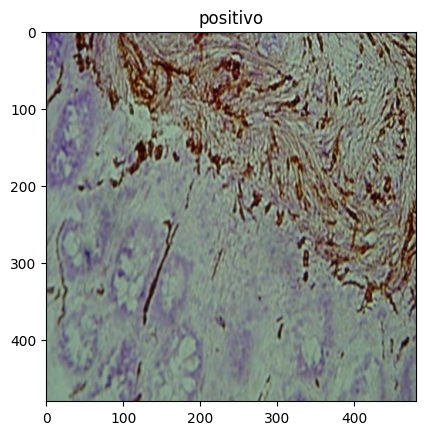

In [54]:
test_image(os.path.join(test_path, "positivo/test_pos-2.jpg"), vgg, process=False, from_logits=True) 

In [ ]:
gap_weights = vgg.layers[-1].get_weights()[0]
gap_weights.shape

cam_model = tf.keras.Model(inputs=vgg.input, outputs=[vgg.layers[-3].output, vgg.layers[-1].output])
cam_model.summary()

In [ ]:
convert_and_classify(os.path.join(test_path, 'test_pos-2.jpg'), upscaling=480/15 , process=False)

In [ ]:
convert_and_classify(os.path.join(test_path, 'test_neg-1.jpg'), upscaling=480/15 , process=False)

In [ ]:
convert_and_classify(os.path.join(test_path, 'test_pos-3.jpg'), upscaling=480/15 , process=False)

## Modelo ResNET50

![](https://upload.wikimedia.org/wikipedia/commons/9/98/ResNet50.png)

Reference

[Deep Residual Learning for Image Recognition (CVPR 2015)](https://arxiv.org/abs/1512.03385)



In [160]:
def build_resnet50():
    
    base_model = tf.keras.applications.resnet.ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    
    for layer in base_model.layers[:-4]:
        layer.trainable=False
    
    x = tf.keras.applications.resnet50.preprocess_input(base_model.input)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    
    output = Dense(units = 1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    # model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy'])
    # model.summary()
    
    return model

def resnet_process_inputs(input_images, labels):
    input_images = tf.cast(input_images, tf.float32)
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
    
    return output_ims, labels


In [161]:
K.clear_session()

resnet50 = build_resnet50()
model_resnet50 = MyModel(resnet50.input, resnet50.output)

model_resnet50.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=[keras.metrics.BinaryAccuracy()])

94765736/94765736 [==============================] - 9s 0us/step


In [162]:
model_resnet50.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 480, 480, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 480, 480, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 15, 15, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                          

In [164]:
history = model_resnet50.fit(x=train_ds,
                       validation_data=val_ds,
                       epochs=20,
                       #callbacks=[PlotLearning()],
                       verbose=2
                      )

Epoch 1/20
17/17 - 17s - loss: 2.0768 - binary_accuracy: 0.6420 - val_loss: 0.3636 - val_binary_accuracy: 0.8438 - 17s/epoch - 1s/step
Epoch 2/20
17/17 - 4s - loss: 0.3984 - binary_accuracy: 0.8093 - val_loss: 0.2637 - val_binary_accuracy: 0.9375 - 4s/epoch - 231ms/step
Epoch 3/20
17/17 - 4s - loss: 0.4047 - binary_accuracy: 0.8088 - val_loss: 0.1964 - val_binary_accuracy: 0.9375 - 4s/epoch - 238ms/step
Epoch 4/20
17/17 - 4s - loss: 0.3160 - binary_accuracy: 0.8750 - val_loss: 0.2529 - val_binary_accuracy: 0.9062 - 4s/epoch - 233ms/step
Epoch 5/20
17/17 - 4s - loss: 0.1977 - binary_accuracy: 0.9261 - val_loss: 0.0553 - val_binary_accuracy: 1.0000 - 4s/epoch - 231ms/step
Epoch 6/20
17/17 - 4s - loss: 0.1276 - binary_accuracy: 0.9455 - val_loss: 1.1381 - val_binary_accuracy: 0.5000 - 4s/epoch - 228ms/step
Epoch 7/20
17/17 - 5s - loss: 0.2900 - binary_accuracy: 0.9066 - val_loss: 0.0181 - val_binary_accuracy: 1.0000 - 5s/epoch - 272ms/step
Epoch 8/20
17/17 - 4s - loss: 0.2220 - binary_acc

In [170]:
test_loss, test_acc = model_resnet50.evaluate(test_ds, verbose=2)

print('\nTest accuracy:', test_acc)

2/2 - 1s - loss: 0.0021 - binary_accuracy: 1.0000 - 1s/epoch - 588ms/step

Test accuracy: 1.0


In [167]:
preds, labels = model_resnet50.predict(test_ds)
preds = np.where(preds>0.5,1.0,0.0)
my_pred(labels, preds)

2/2 [==============================] - 1s 267ms/step
Acurácia: 1.0
Precisão: 1.0
Recall: 1.0
ROC AUC: 1.0
F1: 1.0


In [171]:
confusion_matrix(labels, preds)

array([[10,  0],
       [ 0,  7]])

In [59]:
gap_weights = resnet50.layers[-1].get_weights()[0]

cam_model = tf.keras.Model(inputs=resnet50.input, outputs=(resnet50.layers[-3].output, resnet50.layers[-1].output))
cam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 480, 480, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 486, 486, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 240, 240, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 240, 240, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
convert_and_classify(os.path.join(test_path, 'test_pos-1.jpg'), upscaling=480/15, process=False)

In [ ]:
convert_and_classify(os.path.join(test_path, 'test_pos-2.jpg'), upscaling=480/15, process=False)

In [ ]:
convert_and_classify(os.path.join(test_path, 'test_neg-1.jpg'), upscaling=480/15, process=False)